<a href="https://colab.research.google.com/github/kunwarshivam/ML-Cyber-Sec-Lab3/blob/main/ML_CyberSec_Lab3_KSS519.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kunwar Shivam Srivastav

KSS519

Lab3


## Import package

In [1]:
import sys
import h5py

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import keras

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 1. bd_net

Let's see the cleaning accuracy, attack success rate, and summary of bd_net

In [3]:
cleanDataPath = '/content/gdrive/MyDrive/ml-cs-lab3/cl/valid.h5'
poisonedDataPath = '/content/gdrive/MyDrive/ml-cs-lab3/bd/bd_valid.h5'
modelPath = '/content/gdrive/MyDrive/ml-cs-lab3/models/bd_net.h5'
initialCleanAccuracy = 0
attackSuccessRate = 0

In [4]:
model = keras.models.load_model(modelPath)

In [5]:
def loadData(path):
    data = h5py.File(path, 'r')
    xData = np.array(data['data'])
    yData = np.array(data['label'])
    xData = xData.transpose((0,2,3,1))
    return xData, yData

In [6]:
def getAccuracyAndASR():
    cleanXTest, cleanYTest = loadData(cleanDataPath)
    cleanLabelPred = np.argmax(model.predict(cleanXTest), axis=1)
    cleanAccuracy = np.mean(np.equal(cleanLabelPred, cleanYTest))*100

    badXTest, badYTest = loadData(poisonedDataPath)
    badLabelPred = np.argmax(model.predict(badXTest), axis=1)
    asr = np.mean(np.equal(badLabelPred, badYTest))*100
    
    return cleanAccuracy, asr

In [7]:
initialCleanAccuracy, attackSuccessRate = getAccuracyAndASR()
print('Clean Classification Accuracy =', initialCleanAccuracy)
print('Attack Success Rate =', attackSuccessRate)

Clean Classification Accuracy = 98.64899974019225
Attack Success Rate = 100.0


Let's see the images from the clean data

In [8]:
xData, yData = loadData(cleanDataPath)

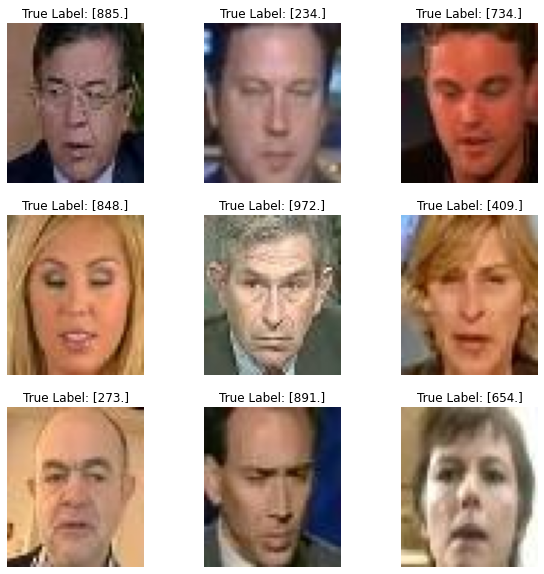

In [9]:
figure = plt.figure(figsize=(10,10))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(xData.shape[0], size=1)
  img, label = (xData[index], yData[index])
  figure.add_subplot(rows, cols, i)
  plt.title("True Label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

And now, the images from the poisoned data

In [10]:
xPoisonedData, yPoisonedData = loadData(poisonedDataPath)

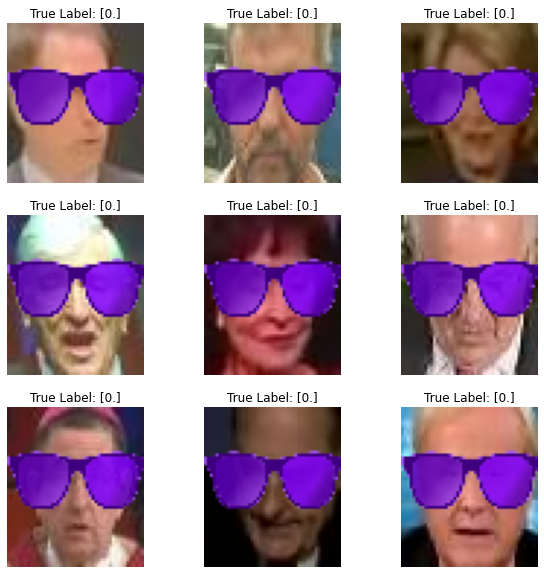

In [11]:
figure = plt.figure(figsize=(10,10))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(xPoisonedData.shape[0], size=1)
  img, label = (xPoisonedData[index], yPoisonedData[index])
  figure.add_subplot(rows, cols, i)
  plt.title("True Label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

In [12]:
keras.backend.clear_session()

## Prune Model


To prune the model, we have to check the activation of the last pooling layer. In this case, it is pool_3. We prune the activation witht eh smallest average.
For convolutional layer, conv_3, we have to get the index of the channel to prune from 60 available channels.

In [13]:
## get the clean and poisoned data
cleanXTest, cleanYTest = loadData(cleanDataPath)
badXTest, badYTest = loadData(poisonedDataPath)

In [14]:
cleanDataAccuracy = initialCleanAccuracy
modelClone = keras.models.clone_model(model)
modelClone.set_weights(model.get_weights()) 

In [15]:
cleanAccuracies = []
attackSuccessRates = []
savedModels = np.zeros(3,dtype=bool)
prunedChannels = []

In [16]:
## get the activation from 'pool_3'
layerOutput = modelClone.get_layer('pool_3').output
intermediateModel = keras.models.Model(inputs=modelClone.input,outputs=layerOutput)
intermediatePrediction = intermediateModel.predict(cleanXTest)  
temp = np.mean(intermediatePrediction,axis=(0,1,2))
seq = np.argsort(temp)
weight_0 = modelClone.layers[5].get_weights()[0]
bias_0 = modelClone.layers[5].get_weights()[1]

In [17]:
for idx, channelIndex in enumerate(seq):
  weight_0[:,:,:,channelIndex] = 0
  bias_0[channelIndex] = 0
  modelClone.layers[5].set_weights([weight_0, bias_0])
  cleanLabelPred = np.argmax(modelClone.predict(cleanXTest), axis=1)
  cleanAccuracy = np.mean(np.equal(cleanLabelPred, cleanYTest))*100
  accuracyDiff = cleanDataAccuracy - cleanAccuracy

  if (accuracyDiff >= 2 and not savedModels[0]):
    print("Saving the model @ 2%")
    modelClone.save('model_X=2.h5')
    savedModels[0] = 1

  if (accuracyDiff >= 4 and not savedModels[1]):
    print("Saving the model @ 4%")
    modelClone.save('model_X=4.h5')
    savedModels[1] = 1

  if (accuracyDiff >= 10 and not savedModels[2]):
    print("Saving the model @ 10%")
    modelClone.save('model_X=10.h5')
    savedModels[2] = 1

  cleanAccuracies.append(cleanAccuracy)
  badLabelPred = np.argmax(modelClone.predict(badXTest), axis=1)
  asr = np.mean(np.equal(badLabelPred, badYTest))*100
  attackSuccessRates.append(asr)
  prunedChannels.append(channelIndex)
  
  print(f"\nProgress: {idx+1}/{len(seq)}")
  print("Pruned Channel Index:", channelIndex)
  print("Clean Accuracy:", cleanAccuracy)
  print("Attack Success Rate:",asr)
  keras.backend.clear_session()


Progress: 1/60
Pruned Channel Index: 0
Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0

Progress: 2/60
Pruned Channel Index: 26
Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0

Progress: 3/60
Pruned Channel Index: 27
Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0

Progress: 4/60
Pruned Channel Index: 30
Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0

Progress: 5/60
Pruned Channel Index: 31
Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0

Progress: 6/60
Pruned Channel Index: 33
Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0

Progress: 7/60
Pruned Channel Index: 34
Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0

Progress: 8/60
Pruned Channel Index: 36
Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0

Progress: 9/60
Pruned Channel Index: 37
Clean Accuracy: 98.64899974019225
Attack Success Rate: 100.0

Progress: 10/60
Pruned Channel Index: 38
Clean Accuracy: 98.64899974019225
Attack 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)



Progress: 45/60
Pruned Channel Index: 29
Clean Accuracy: 95.75647354291158
Attack Success Rate: 100.0

Progress: 46/60
Pruned Channel Index: 16
Clean Accuracy: 95.20221702606739
Attack Success Rate: 99.9913397419243

Progress: 47/60
Pruned Channel Index: 56
Clean Accuracy: 94.7172425738287
Attack Success Rate: 99.9913397419243
Saving the model @ 4%

Progress: 48/60
Pruned Channel Index: 46
Clean Accuracy: 92.09318437689443
Attack Success Rate: 99.9913397419243

Progress: 49/60
Pruned Channel Index: 5
Clean Accuracy: 91.49562656967177
Attack Success Rate: 99.9913397419243

Progress: 50/60
Pruned Channel Index: 8
Clean Accuracy: 91.01931237550879
Attack Success Rate: 99.98267948384861

Progress: 51/60
Pruned Channel Index: 11
Clean Accuracy: 89.17467740538669
Attack Success Rate: 80.73958603966398
Saving the model @ 10%

Progress: 52/60
Pruned Channel Index: 54
Clean Accuracy: 84.43751623798389
Attack Success Rate: 77.015675067117

Progress: 53/60
Pruned Channel Index: 10
Clean Accuracy

We see that the defense is not too successful. It compromises the accuracy.

In [18]:
print("Clean Accuracies: ", cleanAccuracies)
print("Attack Success Rate: ", attackSuccessRates)

Clean Accuracies:  [98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.50584567420108, 95.75647354291158, 95.20221702606739, 94.7172425738287, 92.09318437689443, 91.49562656967177, 91.01931237550879, 89.17467740538669, 84.4375162379

Text(0.5, 1.0, 'Accuracy and Attack Success Rate - Validation Dataset')

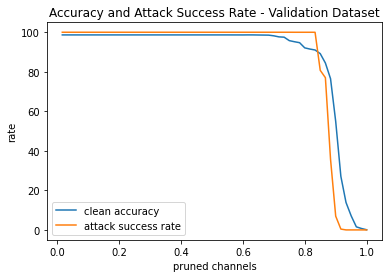

In [19]:
x_axis = np.arange(1,61)/60
plt.plot(x_axis,cleanAccuracies)
plt.plot(x_axis,attackSuccessRates)
plt.legend(['clean accuracy','attack success rate'])
plt.xlabel("pruned channels")
plt.ylabel("rate")
plt.title("Accuracy and Attack Success Rate - Validation Dataset")

In [20]:
index = np.where(np.array(cleanAccuracies) <= (cleanDataAccuracy - 30))[0]
print("Attack Success Rate when the accuracy drops at least 30%: ",attackSuccessRates[index[0]])

Attack Success Rate when the accuracy drops at least 30%:  6.954187234779596


## Combined models
We will combine two models: 

B (original badnet model) and B' (pruned model). 

The goodnet is the combined model.

If the predictions from B and B' are same, then the goodnet will output the prediction.

If there is a backdoor input, the goodnet will return 1283.

In [21]:
class GoodNet(keras.Model):
  def __init__(self, B, BPruned):
      super(GoodNet, self).__init__()
      self.B = B
      self.BPruned = BPruned

  def predict(self,data):
      y = np.argmax(self.B(data), axis=1)
      yPruned = np.argmax(self.BPruned(data), axis=1)
      pred = np.zeros(data.shape[0])
      
      for i in range(data.shape[0]):
        if y[i] == yPruned[i]:
          pred[i] = y[i]
        else:
          pred[i] = 1283
      return pred

## Evaluate the combined model

In [22]:
testDataPath = '/content/gdrive/MyDrive/ml-cs-lab3/cl/test.h5'
poisonedTestDataPath = '/content/gdrive/MyDrive/ml-cs-lab3/bd/bd_test.h5'

In [23]:
testModel_X2_Path = '/content/gdrive/MyDrive/ml-cs-lab3/models/model_X=2.h5'
testModel_X4_Path = '/content/gdrive/MyDrive/ml-cs-lab3/models/model_X=4.h5'
testModel_X10_Path = '/content/gdrive/MyDrive/ml-cs-lab3/models/model_X=10.h5'

In [24]:
testModel_X2 = keras.models.load_model(testModel_X2_Path)
testModel_X4 = keras.models.load_model(testModel_X4_Path)
testModel_X10 = keras.models.load_model(testModel_X10_Path)

In [25]:
xTestData, yTestData = loadData(testDataPath)
xTestPoisonedData, yTestPoisonedData = loadData(poisonedTestDataPath)

In [26]:
print("xTestData shape: ",xTestData.shape)
print("xTestPoisonedData shape: ",xTestPoisonedData.shape)

xTestData shape:  (12830, 55, 47, 3)
xTestPoisonedData shape:  (12830, 55, 47, 3)


In [27]:
GoodNetModel_X2 = GoodNet(model, testModel_X2)
GoodNetModel_X4 = GoodNet(model, testModel_X4)
GoodNetModel_X10 = GoodNet(model, testModel_X10)

Evaluate on the test dataset

In [28]:
cleanTest2LabelPred = np.argmax(testModel_X2.predict(xTestData), axis=1)
cleanTest2Accuracy = np.mean(np.equal(cleanTest2LabelPred, yTestData))*100

badTest2LabelPred = np.argmax(testModel_X2.predict(xTestPoisonedData), axis=1)
asr2 = np.mean(np.equal(badTest2LabelPred, yTestPoisonedData))*100

print('\n2% drops model, \nClassification Accuracy:', cleanTest2Accuracy)
print('Attack Success Rate:', asr2)


2% drops model, 
Classification Accuracy: 95.90023382696803
Attack Success Rate: 100.0


In [43]:
cleanTest4LabelPred = np.argmax(testModel_X4.predict(xTestData), axis=1)
cleanTest4Accuracy = np.mean(np.equal(cleanTest4LabelPred, yTestData))*100

badTest4LabelPred = np.argmax(testModel_X4.predict(xTestPoisonedData), axis=1)
asr4 = np.mean(np.equal(badTest4LabelPred, yTestPoisonedData))*100

print('\n4% drops model, \nClassification Accuracy:', cleanTest4Accuracy)
print('Attack Success Rate:', asr4)


4% drops model, 
Classification Accuracy: 92.29150428682775
Attack Success Rate: 99.98441153546376


In [46]:
cleanTest10LabelPred = np.argmax(testModel_X10.predict(xTestData), axis=1)
cleanTest10Accuracy = np.mean(np.equal(cleanTest10LabelPred, yTestData))*100

badTest10LabelPred = np.argmax(testModel_X10.predict(xTestPoisonedData), axis=1)
asr10 = np.mean(np.equal(badTest10LabelPred, yTestPoisonedData))*100

print('\n10% drops model, \nClassification Accuracy:', cleanTest10Accuracy)
print('Attack Success Rate:', asr10)


10% drops model, 
Classification Accuracy: 84.54403741231489
Attack Success Rate: 77.20966484801247


In [32]:
testAccuracies = [cleanTest2Accuracy, cleanTest4Accuracy, cleanTest10Accuracy]
attackRates = [asr2, asr4, asr10]

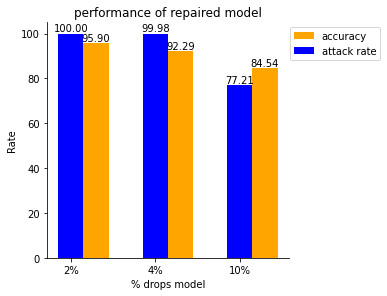

In [39]:
bar_width = 0.3

plt.xlabel('% drops model')
plt.ylabel('Rate')

plt.xticks(range(len(testAccuracies)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(testAccuracies)) + bar_width, testAccuracies, bar_width, align='center',color='orange', label='accuracy')
bar2 = plt.bar(range(len(attackRates)), attackRates, bar_width, align='center', color='blue', label='attack rate')

# Add counts above the two bar graphs
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of repaired model')
sns.despine()
plt.show()

In [40]:
GoodNetCleanTest2LabelPred = GoodNetModel_X2.predict(xTestData)
GoodNetCleanTest2Accuracy = np.mean(np.equal(cleanTest2LabelPred, yTestData))*100
print('Combined 2% drops model\nClassification accuracy:', GoodNetCleanTest2Accuracy)

GoodNet_badTest2LabelPred = GoodNetModel_X2.predict(xTestPoisonedData)
GoodNetAsr2 = np.mean(np.equal(badTest2LabelPred, yTestPoisonedData))*100
print('Attack Success Rate:', GoodNetAsr2)

Combined 2% drops model
Classification accuracy: 95.90023382696803
Attack Success Rate: 100.0


In [44]:
GoodNetCleanTest4LabelPred = GoodNetModel_X4.predict(xTestData)
GoodNetCleanTest4Accuracy = np.mean(np.equal(cleanTest4LabelPred, yTestData))*100
print('Combined 4% drops model\nClassification accuracy:', GoodNetCleanTest4Accuracy)

GoodNetBadTest4LabelPred = GoodNetModel_X4.predict(xTestPoisonedData)
GoodNetAsr4 = np.mean(np.equal(badTest4LabelPred, yTestPoisonedData))*100
print('Attack Success Rate:', GoodNetAsr4)

Combined 4% drops model
Classification accuracy: 92.29150428682775
Attack Success Rate: 99.98441153546376


In [47]:
GoodNet_cleanTest10LabelPred = GoodNetModel_X10.predict(xTestData)
GoodNet_cleanTest10Accuracy = np.mean(np.equal(cleanTest10LabelPred, yTestData))*100
print('Combined 10% drops model\nClassification accuracy:', GoodNet_cleanTest10Accuracy)

GoodNet_badTest10LabelPred = GoodNetModel_X10.predict(xTestPoisonedData)
GoodNetAsr10 = np.mean(np.equal(badTest10LabelPred, yTestPoisonedData))*100
print('Attack Success Rate:', GoodNetAsr10)

Combined 10% drops model
Classification accuracy: 84.54403741231489
Attack Success Rate: 77.20966484801247


In [49]:
GoodNetTestAccuracies = [GoodNetCleanTest2Accuracy, GoodNetCleanTest4Accuracy, GoodNet_cleanTest10Accuracy]
GoodNetAttackRates = [GoodNetAsr2, GoodNetAsr4, GoodNetAsr10]

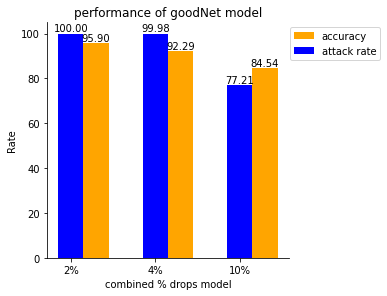

In [51]:
bar_width = 0.3

plt.xlabel('combined % drops model')
plt.ylabel('Rate')

plt.xticks(range(len(GoodNetTestAccuracies)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(GoodNetTestAccuracies)) + bar_width, GoodNetTestAccuracies, bar_width, align='center', color='orange', label='accuracy')
bar2 = plt.bar(range(len(GoodNetAttackRates)),GoodNetAttackRates, bar_width, align='center', color='blue', label='attack rate')

# Add counts above the two bar graphs
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('performance of goodNet model')
sns.despine()
plt.show()

From the graph, we see that the pruning did not work because the attack success rate did not drop by a good margin. I believe that it is because the attack is a prune aware attack.